In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [148]:
df = pd.read_csv("/Users/danmizrahi/Desktop/causalInference/CausalInferenceProject/Simulated_Data/Training_data_3000.csv", index_col=0)
df = pd.get_dummies(df, dtype=float)
df

,Prior,b_mean_E,b_mean_N,b_mean_S,b_mean_W,b_std_E,b_std_N,b_std_S,b_std_W,d_E,d_N,d_S,d_W,T,Y
0,10194.59,1.030772,0.983781,0.990791,0.921146,0.033123,0.071297,0.046838,0.061928,479,447,506,419,2,29170.83
1,6406.34,0.984971,0.924783,0.904248,1.046082,0.079525,0.055213,0.028621,0.137850,342,368,339,388,0,6168.31
2,10178.21,1.019699,0.919077,1.089345,1.083659,0.132676,0.071688,0.021367,0.064772,432,455,473,440,0,10672.61
3,30058.77,1.020655,1.014600,0.996519,0.910000,0.149903,0.138777,0.091112,0.000000,504,487,540,534,2,33087.13
4,246748.77,0.983023,0.940251,0.907566,1.092754,0.014569,0.142431,0.039735,0.034851,655,637,608,708,2,48271.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,8396.41,0.983417,0.919912,0.942494,0.904096,0.058103,0.088731,0.066859,0.033494,357,452,437,415,0,9496.51
2996,15842.65,1.103051,0.944819,1.073242,0.987733,0.191734,0.168382,0.165628,0.188172,554,525,546,525,2,37675.97
2997,10921.98,0.909739,1.065268,1.016647,0.973642,0.079671,0.116973,0.112241,0.028926,459,503,501,475,0,10025.24
2998,26874.97,1.002509,1.066973,0.918544,1.070139,0.078001,0.004681,0.029384,0.003633,570,522,515,576,2,35478.76


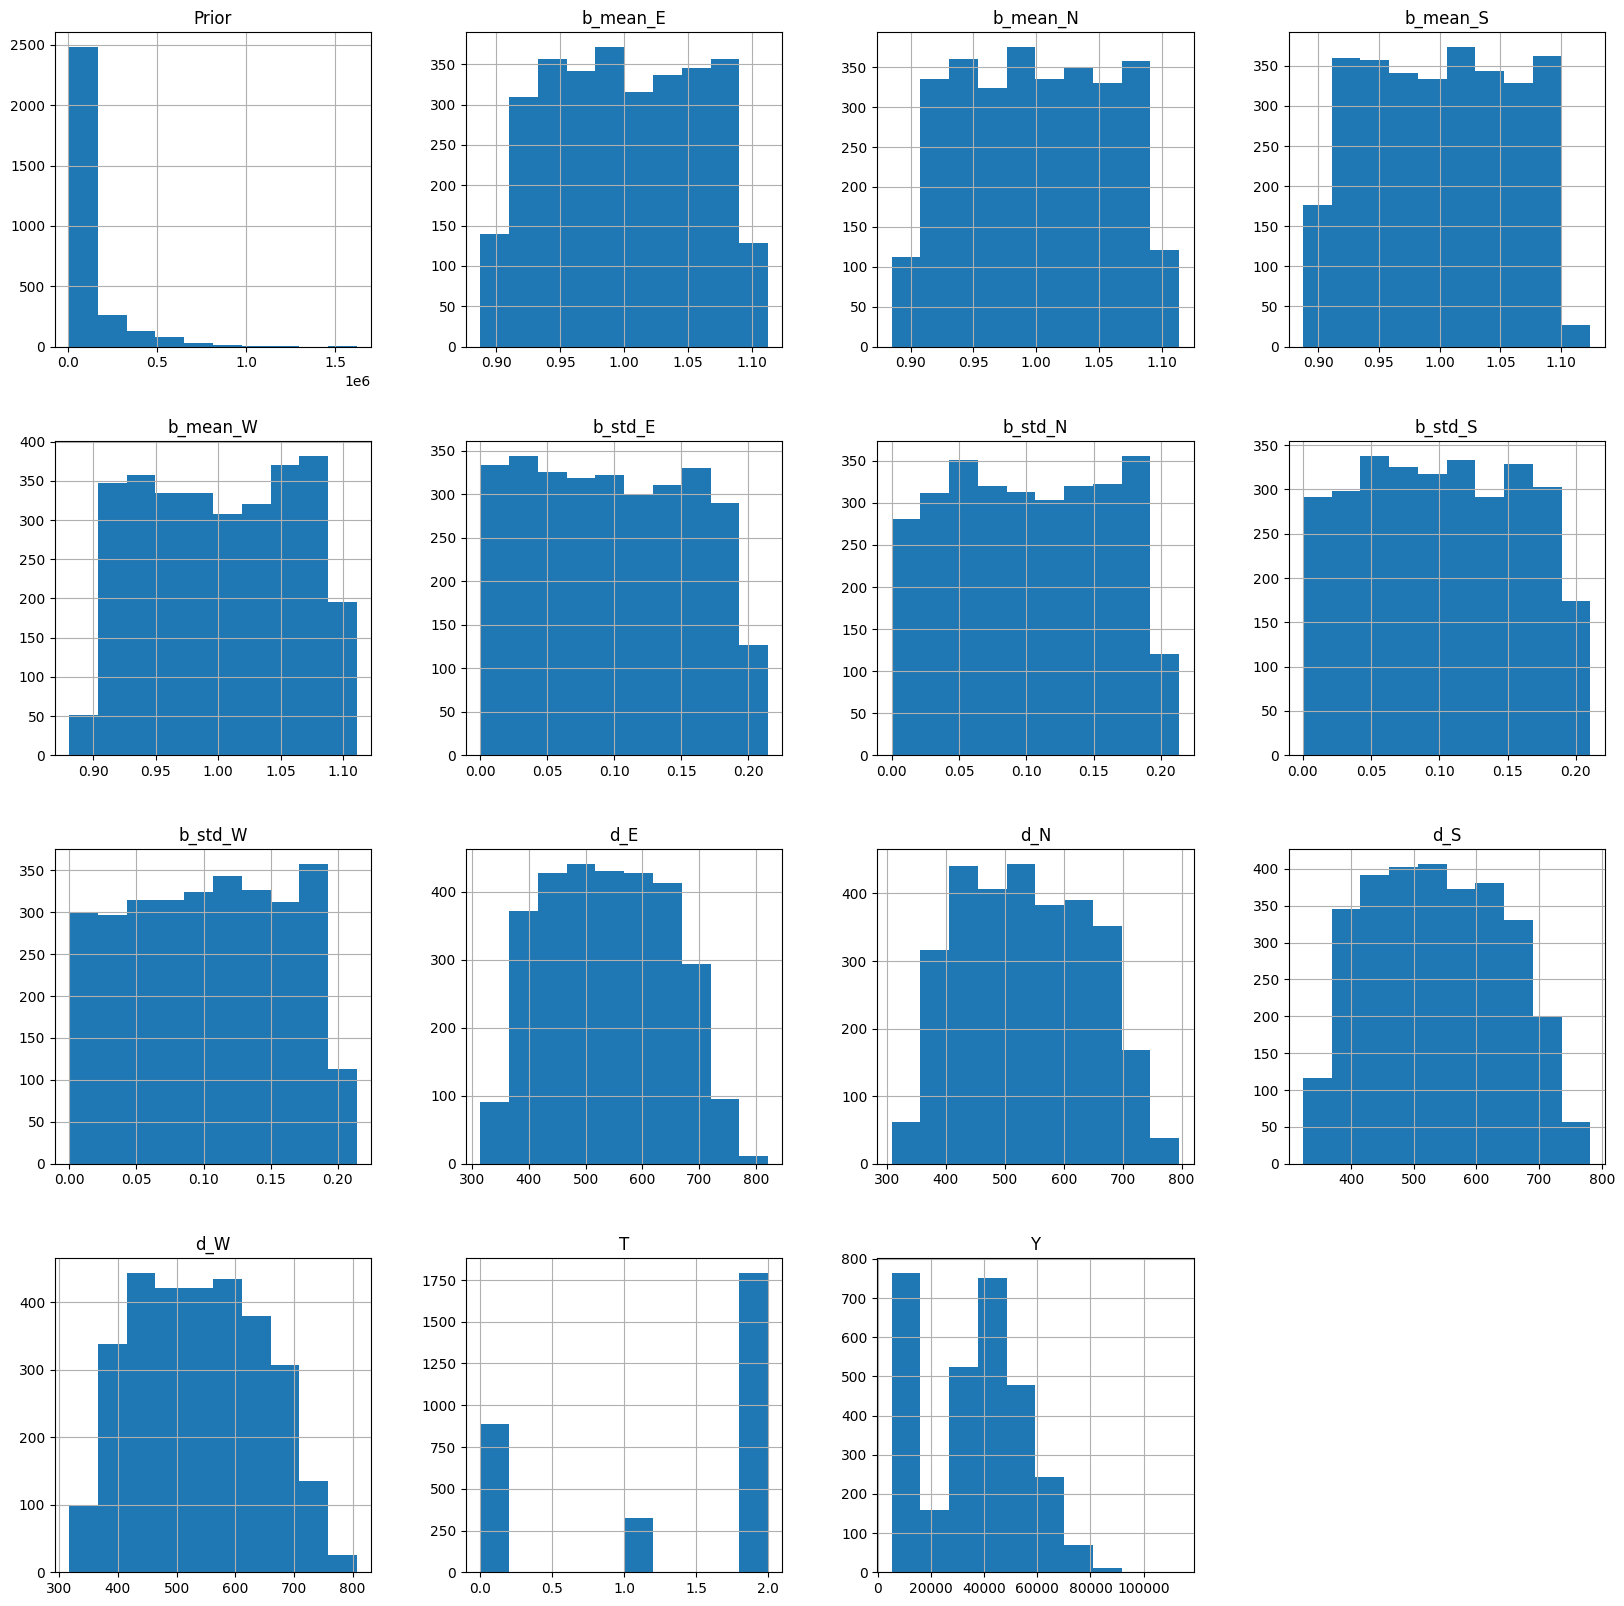

In [149]:
df.hist(figsize=(20, 20))
plt.show()

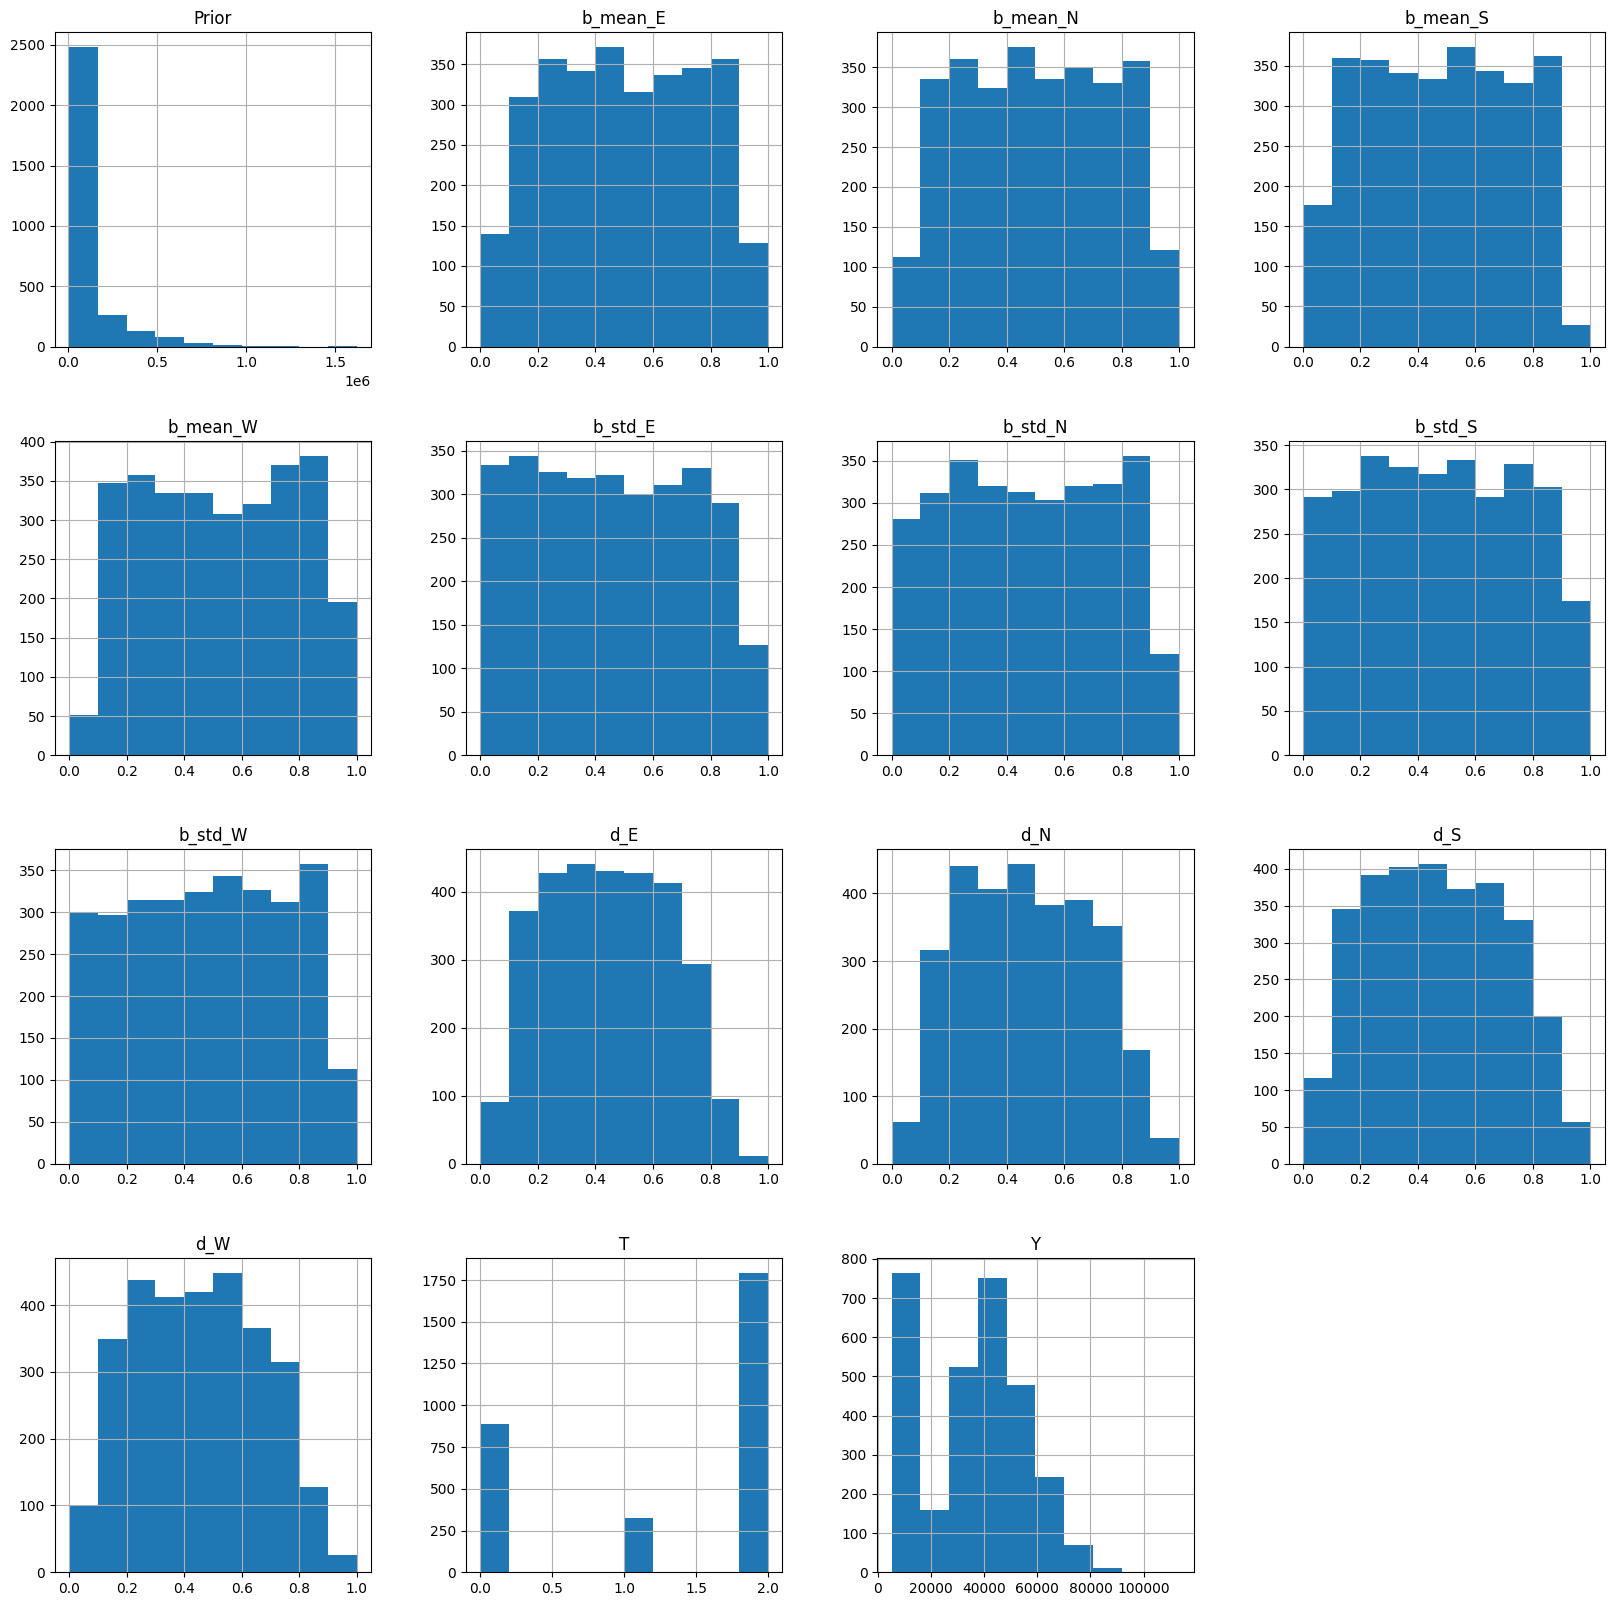

In [150]:
cols_to_scale = ['b_mean_E', 'b_mean_N', 'b_mean_S', 'b_mean_W', 'b_std_E', 'b_std_N', 'b_std_S', 'b_std_W', 'd_E', 'd_N', 'd_S', 'd_W']
scale = MinMaxScaler()
df[cols_to_scale] = scale.fit_transform(df[cols_to_scale])
df.hist(figsize=(20, 20))
plt.show()

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = df.drop(columns=['T','Y'])
a = df['T']

X_train, X_test, a_train, a_test = train_test_split(X, a, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(max_iter=10000, random_state=42)

lr.fit(X_train, a_train)

propensity_scores = lr.predict_proba(X_test)

auc = roc_auc_score(a_test, propensity_scores, multi_class='ovo')
print(f"AUC ovo: {auc}")
auc = roc_auc_score(a_test, propensity_scores, multi_class='ovr')
print(f"AUC ovr: {auc}")
df['propensity_score_lr'] = lr.predict_proba(X)[:, 1]

AUC ovo: 0.8244562530050704
AUC ovr: 0.8909255061870421


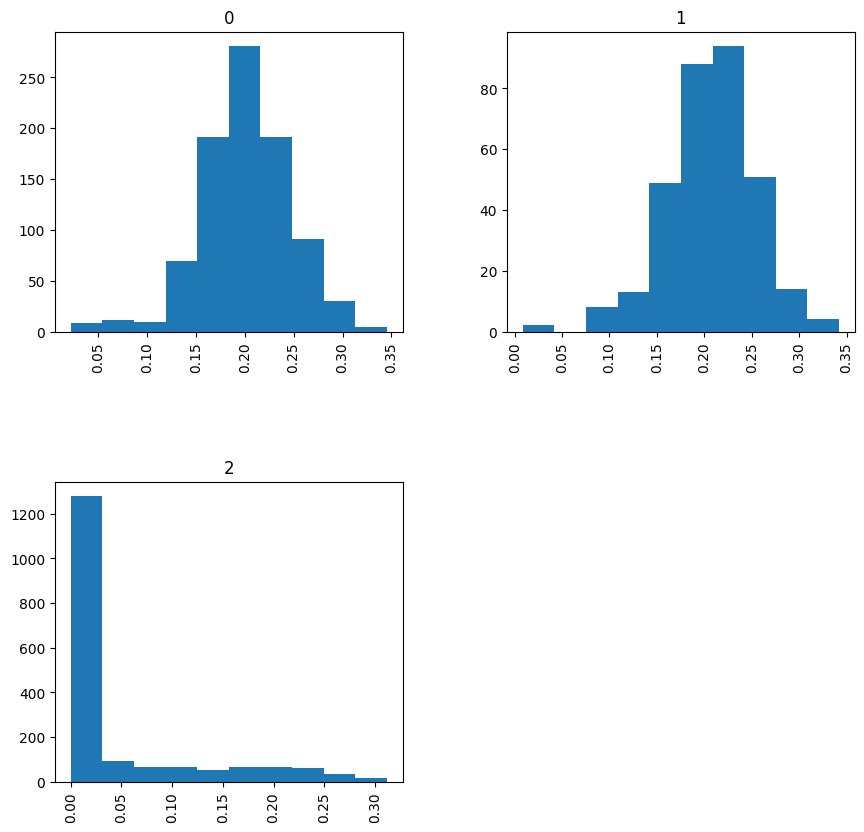

In [152]:
df.hist(column='propensity_score_lr', by='T', figsize=(10, 10))
plt.show()

In [153]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = df.drop(columns=['T','Y'])
a = df['T']

X_train, X_test, a_train, a_test = train_test_split(X, a, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
 
gbm.fit(X_train, a_train)

propensity_scores = gbm.predict_proba(X_test)

auc = roc_auc_score(a_test, propensity_scores, multi_class='ovo')
print(f"AUC ovo: {auc}")
auc = roc_auc_score(a_test, propensity_scores, multi_class='ovr')
print(f"AUC ovr: {auc}")

df['propensity_score_gbm'] = gbm.predict_proba(X)[:, 1] 

AUC ovo: 0.8151024592403182
AUC ovr: 0.8802348634305887


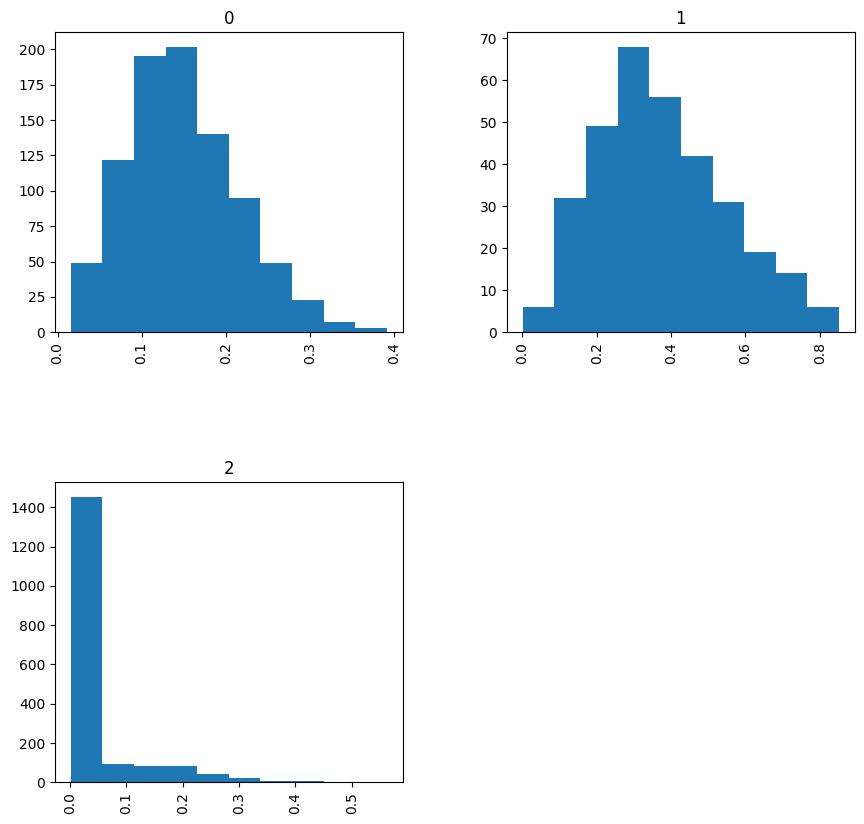

In [154]:
df.hist(column='propensity_score_gbm', by='T', figsize=(10, 10))
plt.show()

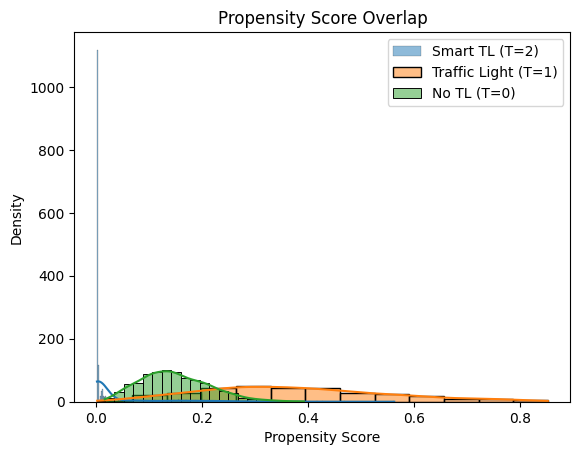

In [155]:
import seaborn as sns

sns.histplot(df[df['T'] == 2]['propensity_score_gbm'], label='Smart TL (T=2)', kde=True)
sns.histplot(df[df['T'] == 1]['propensity_score_gbm'], label='Traffic Light (T=1)', kde=True)
sns.histplot(df[df['T'] == 0]['propensity_score_gbm'], label='No TL (T=0)', kde=True)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Overlap')
plt.legend()
plt.show()

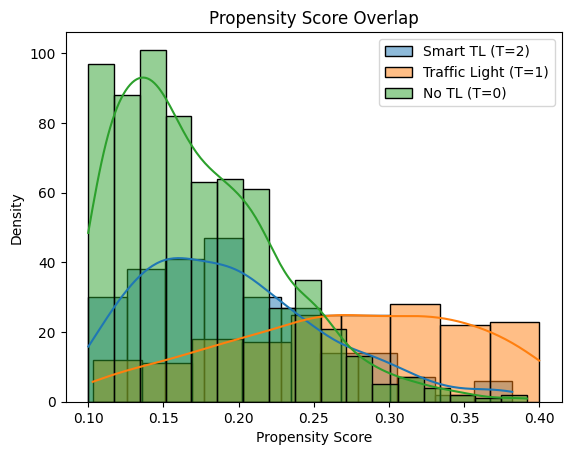

In [156]:
filtered_df = df.loc[df['propensity_score_gbm'] > 0.1]
filtered_df = filtered_df.loc[filtered_df['propensity_score_gbm'] < 0.4]
sns.histplot(filtered_df[filtered_df['T'] == 2]['propensity_score_gbm'], label='Smart TL (T=2)', kde=True)
sns.histplot(filtered_df[filtered_df['T'] == 1]['propensity_score_gbm'], label='Traffic Light (T=1)', kde=True)
sns.histplot(filtered_df[filtered_df['T'] == 0]['propensity_score_gbm'], label='No TL (T=0)', kde=True)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Overlap')
plt.legend()
plt.show()

In [157]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.estimation import IPW, StratifiedStandardization
from causallib.estimation import AIPW
ipw = IPW(LogisticRegression(solver="liblinear"), clip_min=0.05, clip_max=0.95)
std = StratifiedStandardization(LinearRegression())
dr = AIPW(std, ipw)
dr.fit(X, a, df['Y'])

AIPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.5/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, outcome_covariates=None, outcome_model=StratifiedStandardization(learner=LinearRegression()), overlap_weighting=False, predict_proba=False, weight_covariates=None,
     weight_model=IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.5/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=0.95, clip_min=0.05, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear')))

In [158]:
ind_outcomes = dr.estimate_individual_outcome(X, a)
ind_outcomes

T,0,1,2
0,12115.333730,42149.664532,26467.290002
1,5273.695812,30537.808756,12274.743731
2,10963.054824,40587.321105,24234.443554
3,31208.301462,49449.380701,32842.821853
4,6279.355828,48969.454663,54593.464699
...,...,...,...
2995,9444.309921,36736.202432,20310.751173
2996,22035.464081,52081.389456,38812.899011
2997,13033.636868,44957.272785,29825.594851
2998,31747.424021,52603.845362,35663.086165


In [159]:
test_data = pd.read_csv("/Users/danmizrahi/Desktop/causalInference/CausalInferenceProject/Simulated_Data/Testing_data_3000.csv", index_col=0)

def find_index_in_true(idx: int):
    return (3*idx, 3*idx+1, 3*idx+2)

def evaluate_l1_error(test_data, ind_outcomes, Treatments: tuple[int, int]):
    errors = []
    for idx in range(len(ind_outcomes)):
        idxs = find_index_in_true(idx)
        ate = test_data.iloc[idxs[Treatments[0]]]['Y'] - test_data.iloc[idxs[Treatments[1]]]['Y']
        ate_hat = ind_outcomes.iloc[idx,Treatments[0]] - ind_outcomes.iloc[idx,Treatments[1]]
        errors.append(ate - ate_hat)
    return sum(errors) / len(errors)

l1_error = evaluate_l1_error(test_data, ind_outcomes, (0, 1))
print(f"L1 error for T=0 vs T=1: {l1_error}")

L1 error for T=0 vs T=1: 73716.59548003059


In [160]:
from math import sqrt
def evaluate_l2_error(test_data, ind_outcomes, Treatments: tuple[int, int]):
    errors = []
    for idx in range(len(ind_outcomes)):
        idxs = find_index_in_true(idx)
        ate = test_data.iloc[idxs[Treatments[0]]]['Y'] - test_data.iloc[idxs[Treatments[1]]]['Y']
        ate_hat = ind_outcomes.iloc[idx,Treatments[0]] - ind_outcomes.iloc[idx,Treatments[1]]
        errors.append((ate - ate_hat)**2)
    return sqrt(sum(errors) / len(errors))
l2_error = evaluate_l2_error(test_data, ind_outcomes, (0, 1))
print(f"L2 error for T=0 vs T=1: {l2_error}")
l2_error = evaluate_l2_error(test_data, ind_outcomes, (0, 2))
print(f"L2 error for T=0 vs T=2: {l2_error}")
l2_error = evaluate_l2_error(test_data, ind_outcomes, (1, 2))
print(f"L2 error for T=1 vs T=2: {l2_error}")

L2 error for T=0 vs T=1: 179286.6630865287
L2 error for T=0 vs T=2: 196775.6023975107
L2 error for T=1 vs T=2: 20050.36790389891


In [161]:
def evaluate_relative_error(test_data, ind_outcomes, Treatments: tuple[int, int]):
        errors = []
        for idx in range(len(ind_outcomes)):
            idxs = find_index_in_true(idx)
            ate = test_data.iloc[idxs[Treatments[0]]]['Y'] - test_data.iloc[idxs[Treatments[1]]]['Y']
            ate_hat = ind_outcomes.iloc[idx, Treatments[0]] - ind_outcomes.iloc[idx, Treatments[1]]
            errors.append((abs(ate - ate_hat)/abs(ate)))
        return sum(errors) / len(errors)
relative_error = evaluate_relative_error(test_data, ind_outcomes, (0, 1))
print(f"Relative error for T=0 vs T=1: {relative_error}")
relative_error = evaluate_relative_error(test_data, ind_outcomes, (0, 2))
print(f"Relative error for T=0 vs T=2: {relative_error}")
relative_error = evaluate_relative_error(test_data, ind_outcomes, (1, 2))
print(f"Relative error for T=1 vs T=2: {relative_error}")

Relative error for T=0 vs T=1: 1.4004135039283798
Relative error for T=0 vs T=2: 1.2325751764701427
Relative error for T=1 vs T=2: 0.5341966794936761
